Notebook to implement u-net background subtraction

In [1]:
%matplotlib inline

import os
import wandb
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np


In [8]:
# Choose device to run on

print(torch.__version__)

if(torch.backends.mps.is_available()):
    device = "mps"
#elif(torch.cuda.is_available()):
    #device = "cuda"
else:
    device = "cpu"

print(f"Running on {device}...")


2.5.1
Running on cpu...


In [182]:
#clear out gpu memory:

with torch.no_grad():
    torch.cuda.empty_cache()

In [3]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [9]:
# set seed value for repeatability

seed = 42
random.seed(seed)  # Python's random module
torch.manual_seed(seed)  # PyTorch CPU/GPU seed
np.random.seed(seed)  # NumPy random seed

In [10]:
# Start loading up the data

# TODO: update base_path to point to wherever your data is stored
base_path = "../../Data/data/"

train_features = pd.read_csv(f"{base_path}train_features.csv", index_col="id")
test_features = pd.read_csv(f"{base_path}test_features.csv", index_col="id")
train_labels = pd.read_csv(f"{base_path}train_labels.csv", index_col="id")



In [11]:
# Add a 'filepath' column with the full path to each image
# Subdirectories for train and test images
train_images_path = os.path.join(base_path, "train_features")
test_images_path = os.path.join(base_path, "test_features")

train_features['filepath'] = train_features.index.map(
    lambda img_id: os.path.join(train_images_path, f"{img_id}.jpg"))

test_features['filepath'] = test_features.index.map(
    lambda img_id: os.path.join(test_images_path, f"{img_id}.jpg"))

In [12]:
species_labels = sorted(train_labels.columns.unique())


We start diverging from the "standard" example provided by the competition here. Let's pull out all the blank images from the train dataset. Then we'll test/train split on that for training the U-Net.

In [13]:
blank_training_labels = train_labels[train_labels["blank"]==1]

blank_training_images = train_features.loc[blank_training_labels.index]


Since we're only using one class here, this is more of an unsupervised activity than a supervised one. As such, we only have

In [14]:
X_train, X_test = train_test_split(blank_training_images, test_size=0.2, random_state=42)

In [15]:
print(X_train.loc['ZJ006397', "filepath"])

print(X_train.index[874])

../../Data/data/train_features\ZJ006397.jpg
ZJ011519


In [128]:
# Choose batch size here:
BATCH_SIZE = 16

class BackgroundDataset(Dataset):

    def __init__(self, train_features, transform = None, device=device):
        self.data = train_features
        self.device = device
        self.transform = transform

    def __getitem__(self, index):
        image_id = self.data.index[index]
        image = Image.open(self.data.loc[image_id,"filepath"]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        sample = {"image_id": image_id, "image": image}

        return sample
    
    def __len__(self):
        return len(self.data)
    

background_transform = transforms.Compose([
    transforms.Resize((256,256)), 
    transforms.ToTensor()
])




In [129]:
# Create datasets
train_dataset = BackgroundDataset(X_train, transform=background_transform, device=device)
test_dataset =  BackgroundDataset(X_test, transform= background_transform, device=device)




pin = False if device=="cuda" else True

train_loader = DataLoader(
    train_dataset, 
    batch_size = BATCH_SIZE, 
    shuffle = False,
    pin_memory = pin
)

test_loader = DataLoader(
    test_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True,
    pin_memory = pin
)



Ok, lets start working on building the U-Net itself. 

In [ ]:
# guided by: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

class DownConvolve(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.down = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1), #need to add padding so our input doesn't become too small through encoder
            nn.BatchNorm2d(out_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1), #need to add padding so our input doesn't become too small through encoder, actually, mayeb we just need to remove a layer
            nn.BatchNorm2d(out_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
            return self.down(x)

class UpConvolve(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.up = nn.Sequential(
            nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(in_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(in_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(self.in_channels, self.out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x, skip_x):

        x = self.up(x)

        # need to adjust x so that it "fits" with the tensor from skip connection
        height_x, width_x = x.shape[2], x.shape[3]
        height_skip_x, width_skip_x = skip_x.shape[2], skip_x.shape[3]
        height_diff = height_skip_x - height_x
        width_diff = width_skip_x - width_x

        #print(f"Input shape: {x.shape}")
        #print(f"Residual shape: {skip_x.shape}")
        #print(f"height difference: {height_diff}, padding by: {height_diff//2}")
        #print(f"weidth difference: {width_diff}, padding by: {width_diff//2}")

        padded_x = F.pad(x, (width_diff//2, width_diff//2, height_diff//2, height_diff//2))
        
        #print(f"Skip X has size: {skip_x.shape}, Padded_x has shape: {padded_x.shape}")

        out = torch.cat((skip_x, padded_x), dim=1)

        return out


In [ ]:


class UnetModel(nn.Module):

    def __init__(self, input_channel_count, output_class_count):
        super().__init__()

        self.input_channel_count = input_channel_count
        self.output_channel_count = output_class_count

        self.final_up_conv = nn.ConvTranspose2d(128, self.output_channel_count, kernel_size=2, stride=2)

        self.down_layer_1 = DownConvolve(self.input_channel_count, 64)
        self.down_layer_2 = DownConvolve(64, 128)
        self.down_layer_3 = DownConvolve(128, 256)
        self.down_layer_4 = DownConvolve(256, 512)
        self.down_layer_5 = DownConvolve(512, 1024)

        self.up_layer_1 = UpConvolve(1024, 512)
        self.up_layer_2 = UpConvolve(512*2, 256)
        self.up_layer_3 = UpConvolve(256*2, 128)
        self.up_layer_4 = UpConvolve(128*2, 64)
        
    def forward(self, x):
        #print(f"Shape of x: {x.shape}")
        d1 = self.down_layer_1(x)
        #print(f"Shape of d1: {d1.shape}")
        d2 = self.down_layer_2(d1)
        #print(f"Shape of d2: {d2.shape}")
        d3 = self.down_layer_3(d2)
        #print(f"Shape of d3 is: {d3.shape}")
        d4 = self.down_layer_4(d3)
        #print(f"Shape of d4 is: {d4.shape}")
        d5 = self.down_layer_5(d4)
        #print(f"Shape of d5 is: {d5.shape}")

        u1 = self.up_layer_1(d5, d4)
        #print(f"Shape of u1: {u1.shape}")
        u2 = self.up_layer_2(u1, d3) 
        #print(f"Shape of u2: {u2.shape}")
        u3 = self.up_layer_3(u2, d2)
        #print(f"Shape of u3: {u3.shape}")
        u4 = self.up_layer_4(u3, d1)
        #print(f"Shape of u4: {u4.shape}")

        out = self.final_up_conv(u4)
        
        return out
        



In [144]:
LEARNING_RATE = 1e-3
BETA_VALUES = (0.9, 0.99)



unet = UnetModel(3,3).to(device)
criteria = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, betas=BETA_VALUES)


In [22]:
EPOCHS=1

def train_one_epoch(model, train_loader, criterion, optimizer, epoch):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The model being trained.
        train_loader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        epoch (int): Current epoch number.
        cfg (dict): W&B configuration.

    Returns:
        float: Average loss for all batches in the epoch. Summarizing how 
        the model is performing during this epoch
    """
    print(f"Starting training for epoch {epoch}")
    model.train()
    total_loss = 0
    # total_steps = len(train_loader) # num batches in loader
    tracking_loss = []  # List to store loss for every batch

    for batch_n, batch in enumerate(train_loader):
        images = batch["image"].to(device)
        labels = batch["image"].to(device) # to train this, we use the empty frames as both inputs and ground truth labels

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        tracking_loss.append(loss.item())  # Store batch loss for tracking 

        # backward and optimize
        optimizer.zero_grad()
        loss.backward() # wrt
        optimizer.step()


        # Print progress every 100 batches
        if (batch_n + 1 ) % 100 == 0: 
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, EPOCHS, batch_n+1, len(train_loader), loss.item()))
            
    avg_loss = total_loss / len(train_loader)

    return avg_loss, tracking_loss


In [149]:
def evaluate(model, val_loader, criterion, log_counter):
    """
    Evaluate the model on a test/validation dataset.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
        cfg (dict): W&B configuration.

    Returns:
        dict: Metrics including accuracy and average loss.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    log_counter = 0

    # Collect all predictions and labels for metric calculations
    all_outputs = []
    all_ids = []


    
    with torch.no_grad():
        for batch_n, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            labels = batch["image"].to(device)
            image_ids = batch["image_id"]

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_outputs.append(outputs)
            all_ids.append(all_ids)
            



    # Calculate metrics
    avg_loss = total_loss / len(val_loader)
    print(f"Evaluation - Loss: {avg_loss:.4f}")

    return all_outputs[:-5], all_ids[:-5]
    


In [145]:
log_counter = 0
tracking_loss_all = []

for epoch in range(EPOCHS):
    #Training step
    avg_train_loss, tracking_loss = train_one_epoch(unet, 
                                     train_loader, 
                                     criteria, 
                                     optimizer, 
                                     epoch)
    tracking_loss_all.extend(tracking_loss)  # Append to global list
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Train Loss: {avg_train_loss:.4f}")

    
    


Starting training for epoch 0
Input shape: torch.Size([16, 512, 8, 8])
Residual shape: torch.Size([16, 512, 16, 16])
height difference: 8, padding by: 4
weidth difference: 8, padding by: 4
Skip X has size: torch.Size([16, 512, 16, 16]), Padded_x has shape: torch.Size([16, 512, 16, 16])
Shape of u1: torch.Size([16, 1024, 16, 16])
Input shape: torch.Size([16, 256, 24, 24])
Residual shape: torch.Size([16, 256, 32, 32])
height difference: 8, padding by: 4
weidth difference: 8, padding by: 4
Skip X has size: torch.Size([16, 256, 32, 32]), Padded_x has shape: torch.Size([16, 256, 32, 32])
Shape of u2: torch.Size([16, 512, 32, 32])
Input shape: torch.Size([16, 128, 56, 56])
Residual shape: torch.Size([16, 128, 64, 64])
height difference: 8, padding by: 4
weidth difference: 8, padding by: 4
Skip X has size: torch.Size([16, 128, 64, 64]), Padded_x has shape: torch.Size([16, 128, 64, 64])
Shape of u3: torch.Size([16, 256, 64, 64])
Input shape: torch.Size([16, 64, 120, 120])
Residual shape: torch

In [150]:
# Evaluation step
backgrounds, ids = evaluate(unet, test_loader, criteria, log_counter)


Input shape: torch.Size([16, 512, 8, 8])
Residual shape: torch.Size([16, 512, 16, 16])
height difference: 8, padding by: 4
weidth difference: 8, padding by: 4
Skip X has size: torch.Size([16, 512, 16, 16]), Padded_x has shape: torch.Size([16, 512, 16, 16])
Shape of u1: torch.Size([16, 1024, 16, 16])
Input shape: torch.Size([16, 256, 24, 24])
Residual shape: torch.Size([16, 256, 32, 32])
height difference: 8, padding by: 4
weidth difference: 8, padding by: 4
Skip X has size: torch.Size([16, 256, 32, 32]), Padded_x has shape: torch.Size([16, 256, 32, 32])
Shape of u2: torch.Size([16, 512, 32, 32])
Input shape: torch.Size([16, 128, 56, 56])
Residual shape: torch.Size([16, 128, 64, 64])
height difference: 8, padding by: 4
weidth difference: 8, padding by: 4
Skip X has size: torch.Size([16, 128, 64, 64]), Padded_x has shape: torch.Size([16, 128, 64, 64])
Shape of u3: torch.Size([16, 256, 64, 64])
Input shape: torch.Size([16, 64, 120, 120])
Residual shape: torch.Size([16, 64, 128, 128])
heig

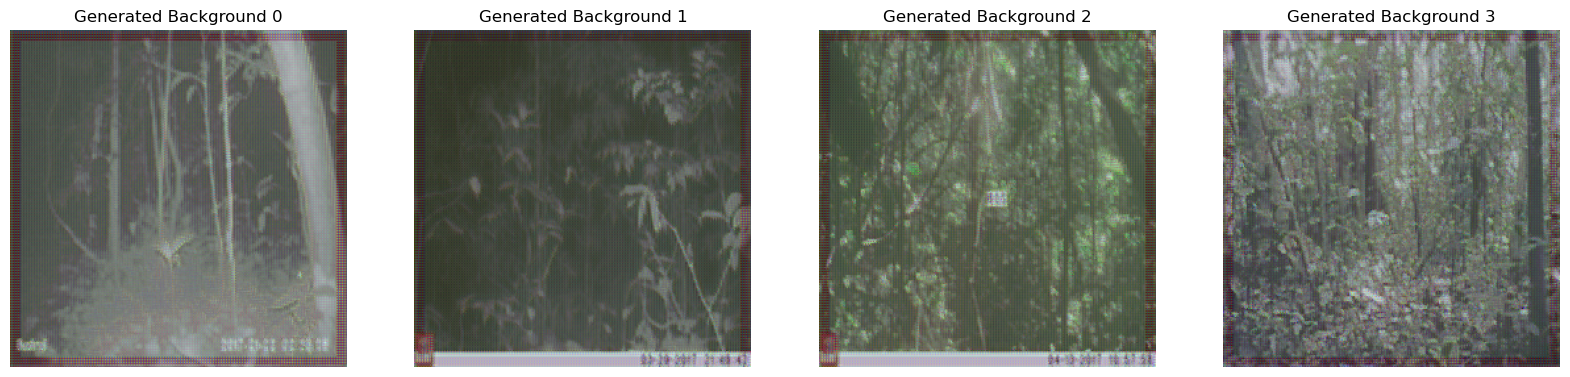

In [177]:
im = backgrounds[1]

def prep_picture(image_tensor, index):
    im = image_tensor[index,:,:,:]
    image = np.transpose(im.numpy(), (1,2,0))
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image-min_val)/(max_val-min_val)
    return normalized_image

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,20))

for idx, ax in enumerate(axes.flat):
    image = prep_picture(im, idx)
    ax.imshow(image)
    ax.set_title(f"Generated Background {idx}")
    ax.axis("off")

plt.show()
